In [1]:
import autorootcwd

In [2]:
import os
print(os.getcwd())

/home/kaka/workspace_py/mlLearning/tutorial


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch import nn
import torch.nn.functional as F
import torchmetrics

import pytorch_lightning as pl
import torchkeras

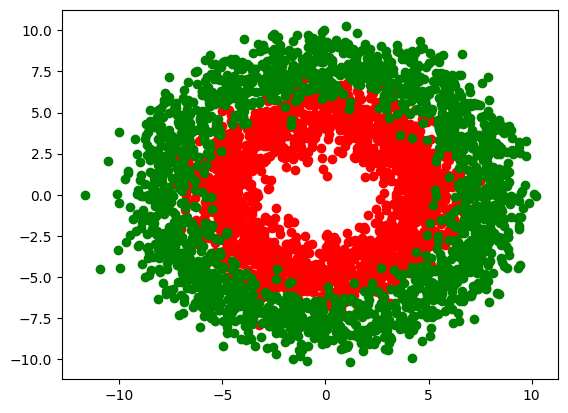

In [4]:
# number of samples

n_positive, n_negative = 2000, 2000
r_p = 5 + np.random.normal(loc=0, scale=1, size=[n_positive, 1])
theta_p = 2 * np.pi * np.random.uniform(low=0, high=1, size=[n_positive, 1])
x_p = np.concatenate([r_p*np.cos(theta_p), r_p*np.sin(theta_p)], axis=1)
y_p = np.ones_like(r_p)

r_n = 8 + np.random.normal(loc=0,scale=1,size=[n_negative,1])
theta_n = 2*np.pi*np.random.uniform(low=0,high=1,size=[n_negative,1])
x_n = np.concatenate([r_n*np.cos(theta_n), r_n*np.sin(theta_n)], axis=1)
y_n=np.zeros_like(r_n)

plt.scatter(x_p[:,0], x_p[:,1], c="r")
plt.scatter(x_n[:,0], x_n[:,1], c="g")
plt.show()

In [5]:
x = np.concatenate([x_p, x_n], axis=0,dtype=np.float32)
y = np.concatenate([y_p, y_n], axis=0,dtype=np.float32)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.1,stratify=y_train,random_state=42)
print(
    x_train.shape[0] / x.shape[0],
    x_valid.shape[0] / x.shape[0],
    x_test.shape[0] / x.shape[0],
)
print(y_test.shape)

0.72 0.08 0.2
(800, 1)


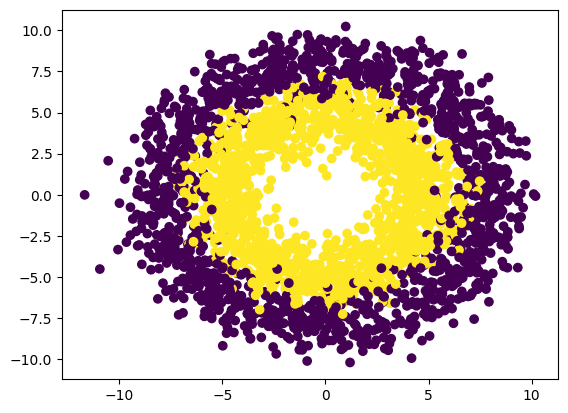

In [6]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
# plt.scatter(x_valid[:, 0], x_valid[:, 1], c=y_valid)
# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.show()

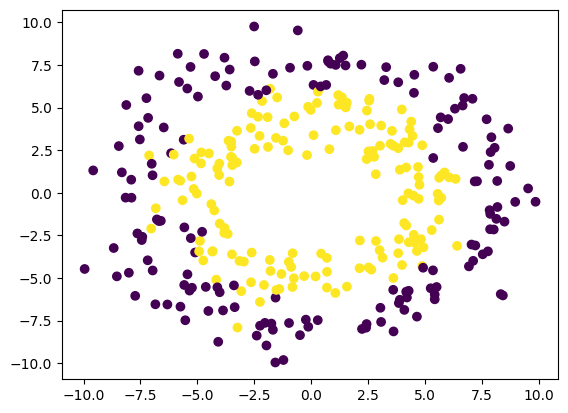

In [7]:
# plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.scatter(x_valid[:, 0], x_valid[:, 1], c=y_valid)
# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.show()

In [8]:
ds_train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
ds_valid = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
ds_test = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

dl_train = DataLoader(ds_train, batch_size=1000, shuffle=True, num_workers=4)
dl_valid = DataLoader(ds_valid, batch_size=1000, shuffle=False, num_workers=4)
dl_test = DataLoader(ds_test, batch_size=1000, shuffle=False, num_workers=4)

In [9]:
for features, labels in dl_train:
    # print(features)
    break

In [10]:
# define the network like torch
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 6)
        self.fc2 = nn.Linear(6, 12)
        self.fc3 = nn.Linear(12, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y


class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0), requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        # preds = preds.argmax(dim=-1)
        preds = torch.where(preds > 0.5, torch.ones_like(preds), torch.zeros_like(preds))
        m = (preds == targets).sum()
        n = targets.shape[0]
        self.correct += m
        self.total += n

        return m / n

    def compute(self):
        return self.correct.float() / self.total

    def reset(self):
        self.correct -= self.correct
        self.total -= self.total

In [11]:
import torchkeras.metrics
# from torchkeras.tabular import StepRunner

# torchkeras.KerasModel.StepRunner = StepRunner

net = Net()

model = torchkeras.KerasModel(
    net,
    loss_fn=nn.BCELoss(),
    metrics_dict={"acc": Accuracy()},
    optimizer=torch.optim.Adam(net.parameters(), lr=1e-2),
    # lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001),
)

from torchkeras import summary

summary(model, input_data=features)

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 6]                   18
Linear-2                                    [-1, 12]                   84
Linear-3                                     [-1, 1]                   13
Total params: 115
Trainable params: 115
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000076
Forward/backward pass size (MB): 0.000145
Params size (MB): 0.000439
Estimated Total Size (MB): 0.000660
--------------------------------------------------------------------------


'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nLinear-1                                     [-1, 6]                   18\nLinear-2                                    [-1, 12]                   84\nLinear-3                                     [-1, 1]                   13\n==========================================================================\nTotal params: 115\nTrainable params: 115\nNon-trainable params: 0\n--------------------------------------------------------------------------\nInput size (MB): 0.000076\nForward/backward pass size (MB): 0.000145\nParams size (MB): 0.000439\nEstimated Total Size (MB): 0.000660\n--------------------------------------------------------------------------'

In [12]:
dl_train

<<<<<< ⚡️ cuda is used >>>>>>


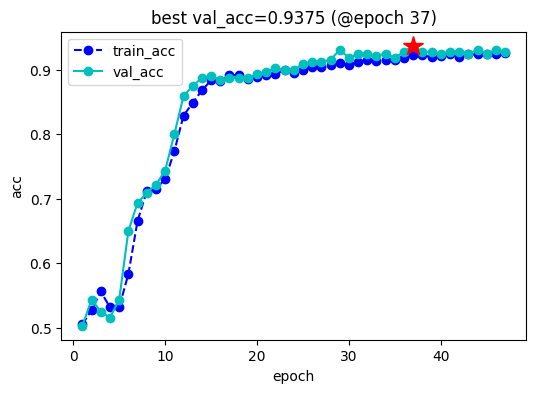

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>> 



In [13]:
# if gpu/mps is available, will auto use it, otherwise cpu will be used.
ckpt_path = "checkpoint"
# model.load_ckpt(ckpt_path) #load trained ckpt and continue training
dfhistory = model.fit(
    train_data=dl_train,
    val_data=dl_valid,
    epochs=300,
    patience=10,
    monitor="val_acc",
    mode="max",
    ckpt_path=ckpt_path,
    plot=True,
)

In [14]:
net = model.net
net.eval()

Net(
  (fc1): Linear(in_features=2, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=1, bias=True)
)

In [15]:
# device = torch.device("cuda")
# x_in = ds_test.to(device)
# pred_y = []
# for features, labels in dl_test:

#     pred_y = net(features)
#     plt.scatter(labels, labels)
#     break
# plt.show()

In [32]:
torch_test = torch.from_numpy(x_test)
pred_y = net(torch_test)
preds = (
    torch.where(pred_y > 0.5, torch.ones_like(pred_y), torch.zeros_like(pred_y))
    .detach()
    .numpy()
)

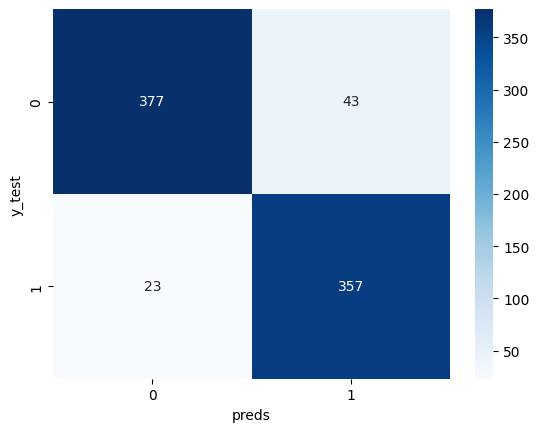

In [ ]:
from sklearn.metrics import confusion_matrix 
# Plot the confusion matrix

cm = confusion_matrix(preds, y_test)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("preds")
plt.ylabel("y_test")
plt.show()

In [ ]:
# 7. 解释
# fpr: 假阳性率（False Positive Rate）。
# tpr: 真阳性率（True Positive Rate），即召回率（Recall）。
# thresholds: 用于计算 fpr 和 tpr 的阈值。
# roc_auc: ROC 曲线下的面积（AUC），用于评估分类器的性能。
# 8. 注意事项
# 如果你的模型是多分类的，可以使用 OneVsRestClassifier 或 OneVsOneClassifier 来处理，或者使用 roc_auc_score 函数来计算多分类的 AUC 值。
# 如果你使用的是 PyTorch 模型，可以通过 torch.nn.functional.softmax 或 torch.nn.functional.sigmoid 来获取预测概率。
# ROC曲线通过展示模型在不同分类阈值下的TPR和FPR，帮助我们直观地理解模型的分类性能。AUC值则提供了一个量化指标，用于比较不同模型的性能。ROC曲线在评估二分类模型时非常有用，尤其是在类别不平衡的情况下。

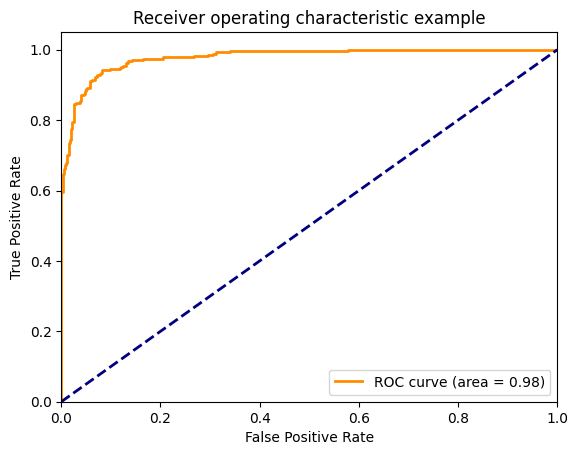

In [ ]:

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pred_y.detach().numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


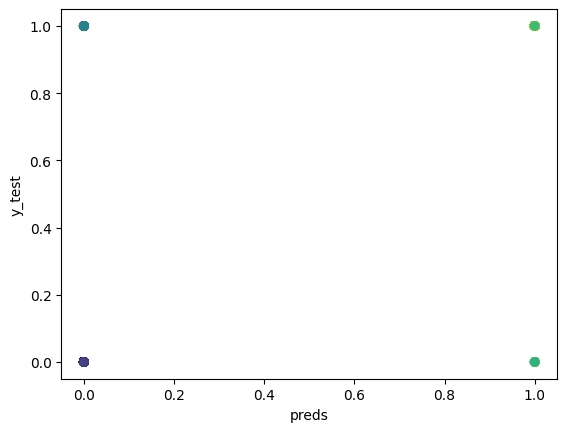

In [ ]:

plt.scatter(preds, y_test, c=pred_y.detach().numpy())
plt.xlabel("preds")
plt.ylabel("y_test")
plt.show()

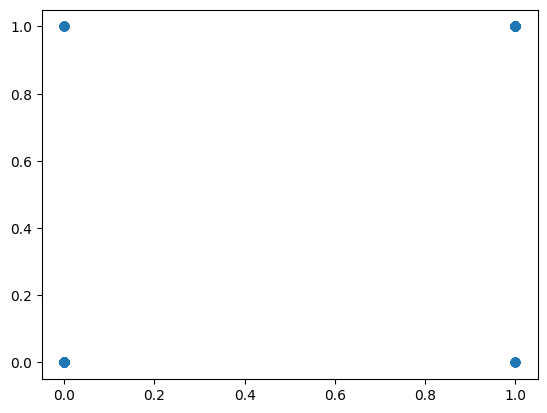

In [18]:
preds = torch.where(pred_y > 0.5, torch.ones_like(pred_y), torch.zeros_like(pred_y)).detach().numpy()
plt.scatter(preds, y_test)
plt.show()

In [19]:
df = pd.DataFrame({"preds": preds.reshape(-1), "y_test": y_test.reshape(-1)})
# 报错 ValueError: Per-column arrays must each be 1-dimensional
df

,preds,y_test
0,1.0,1.0
1,1.0,1.0
2,0.0,0.0
3,0.0,1.0
4,1.0,1.0
...,...,...
795,1.0,1.0
796,1.0,0.0
797,0.0,0.0
798,0.0,0.0


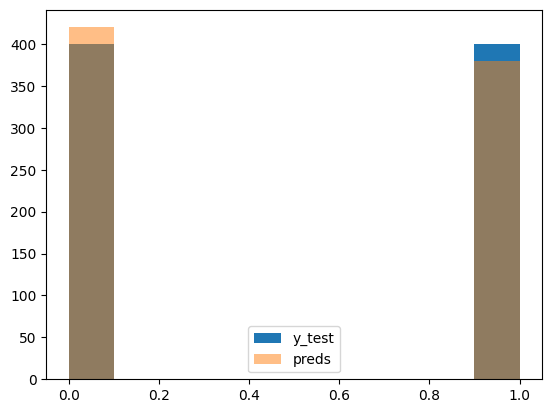

In [20]:
plt.hist(y_test)
plt.hist(preds, alpha=0.5)
plt.legend(["y_test", "preds"])
plt.show()

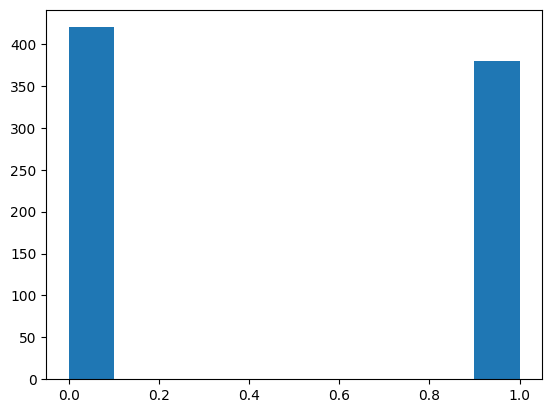

In [21]:
plt.hist(preds)
plt.show()

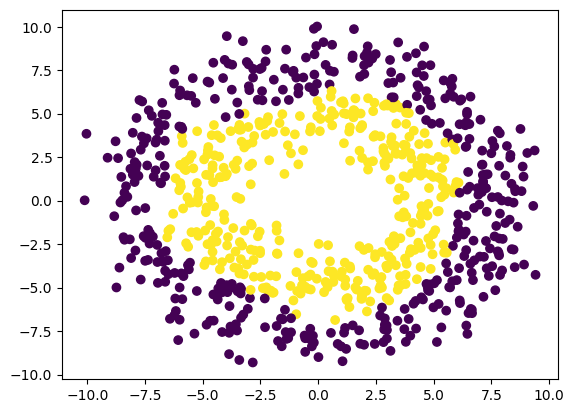

In [22]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=preds)
plt.show()

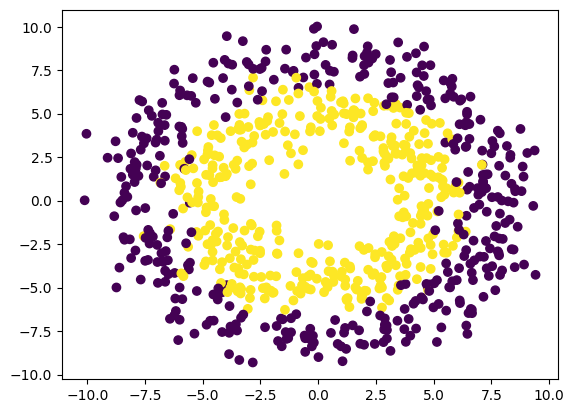

In [23]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.show()

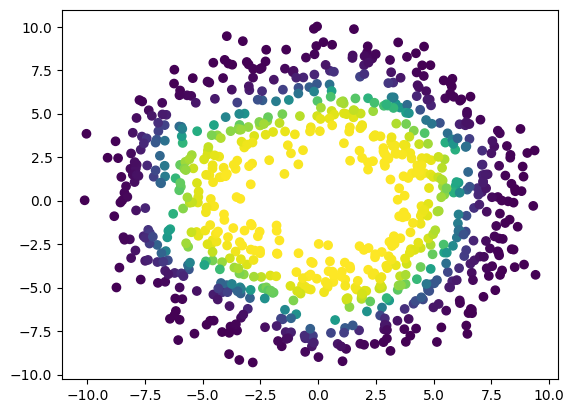

In [24]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=pred_y.detach().numpy())
plt.show()